# Climatology 

### Purpose
This notebook assess how well the QARTOD climatology test, as implemented by OOI, performs with respect to accurately capturing and flagging the passage of a mid-water-column eddy across the OOI Global Argentine Basin array in July-August of 2016. 

### Background
#### QARTOD
As part of the ongoing OOI effort to improve data quality, OOI is implementing Quality Assurance of Real-Time Oceanographic Data (QARTOD) tests on an instrument-by-instrument basis. Led by the United States Integrated Ocean Observing System (U.S. IOOS), the QARTOD effort draws on the ocean observing community to provide manuals, which outline and identify tests to evaluate data quality by variable and instrument type (https://ioos.noaa.gov/project/qartod/). Currently, OOI is focused on implementing the Gross Range and Climatology Tests for the variables associated with CTD, pH and pCO2 sensors. Over the coming months tests will be applied to data collected by pressure sensors, bio-optical sensors, and dissolved oxygen sensors. Ultimately, where and when appropriate, QARTOD tests will be applied to the relevant variables for all OOI sensors.

##### Gross Range Test
The Gross Range test aims to identify data that fall outside either the sensor’s measurement range or is a statistical outlier. OOI identifies failed/bad data with a threshold value based on the calibration range for a given sensor. We also calculate suspicious/interesting data thresholds as the mean ± 3 standard deviations based on the historical OOI data for the variable at the deployed location. Thus, as implemented by OOI, the Gross Range test identifies data which either falls outside of the sensor calibration range, and is thus “bad”, or data that are statistical outliers based on the historic OOI data for that location.

##### Climatology Test
The Climatology Test is a variation on the Gross Range Test, modifying the relevant suspicious/interesting data thresholds for each calendar-month by accounting for seasonal cycles. The OOI time series are short (<8 years) relative to the World Meteorological Organization (WMO) recommended 30-year climatology reference period. We therefore calculate seasonal cycles for a given variable using harmonic analysis, a method that is less susceptible to spurious values that can arise either from data gaps, measurement errors or from the presence of real, but anomalous, geophysical conditions in the 8-year record.  First, we group the data by calendar-month (e.g. January, February, …, December) and calculate the average of each month. Then, the monthly-averaged-data are fit with a two-cycle (annual plus semiannual) harmonic model using ordinary-least-squares. This produces a “climatological” fit for each calendar-month. Next, we calculate the standard deviation for each calendar-month from the climatological-fit and the grouped observations for the month. The thresholds for suspicious/interesting data are set as the climatological-fit ± 3 standard deviations. Occasionally, data gaps may mean that there are no historical observations for a given calendar-month. In these instances, we linearly interpolate the threshold from the nearest months. For sensors mounted on profiler moorings or vehicles, we first subset the data into a series of standardized depth bins to account for differences in seasonality and variability at different depths in the water column. The resulting test identifies data that fall outside of typical seasonal variability determined from the historic OOI data for that location.

---
### Motivation
The goal of this notebook is to assess how well OOI's approach for QARTOD performs for quality control of OOI's timeseries data. 

This is done by comparing the performance of the implemented Gross Range and Climatology tests against two test cases of natural phenomena. The first test case is the freshening of the mid-water-column in the Irminger Sea. CTDs across the Global Irminger Sea have documented a continous long term freshening of the water column from the near surface through 1500 m depth that is captured on all the deployed moorings. We use this freshening to investigate how well the fitting of the gross range threshold performace relative to a long-term trend, and that it is not inappropriately flagging natural variability.

The second test case is the passage of mid-water-column eddy across the Global Irminger Array in July-August 2016. The passage of the eddy is visible as a large warm and saline deviation in the temperature and salinity data of the deployed CTDs. This allows us to test how well does the climatology fitting algorithm respond to a large deviation in the data and if it sufficiently flags the physical phenomena of the eddy with its flags.

#### Arrays
##### Global Argentine Basin
The Global Argentine Basin was an OOI maintained array of surface, subsurface, and profiling moorings in the Argentine Basin of the South Atlantic at (42$^{\circ}$S, 42$^{\circ}$W) from 2015 to 2018. The mooring arrangement can be seen in this schematic: ![figure](../documents/global_array.png). 

The Surface Mooring located at the Apex and the two Flanking Moorings were equipped with CTDs are regularly spaced intervals up to 1500 m of depth. Additionally, the CTDs were placed at the same nominal depths on all three moorings below 30 m of depth.

####


---
### Methods

The purpose of this notebook is to identify and download the datasets with pH and pCO2 data deployed at the Ocean Observatory Initiative's (OOI) Global Irminger Array (60$^{\circ}$N, 39$^{\circ}$W). OOI deploys the following sensors for measuring the ocean carbon system: Sunburst Sensors, LLC. SAMI-pH (PHSEN) pH, SAMI-pCO$_{2}$ seawater measurements, and the Pro-Oceanus pCO2 sensor measurements. The datasets identified here are used in the **```Data_Analysis```** notebook. m

In [1]:
import sys, os
import yaml
import json
import pandas as pd
import numpy as np
import xarray as xr
import datetime
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import the OOINet M2M tool
sys.path.append("/home/andrew/Documents/OOI-CGSN/ooinet/ooinet/")
from m2m import M2M

In [3]:
# Import the QARTOD test fitting
sys.path.append("/home/andrew/Documents/OOI-CGSN/oceanobservatories/ooi-data-explorations/python/ooi_data_explorations/")
from qartod import gross_range, climatology

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from erddapy import ERDDAP
# Connect to the server
erd = ERDDAP(
    server="https://erddap.dataexplorer.oceanobservatories.org/erddap",
    protocol="tabledap"
)

In [6]:
userinfo = yaml.load(open("../../../../QAQC_Sandbox/user_info.yaml"), Loader=yaml.SafeLoader)
username = userinfo["apiname"]
token = userinfo["apikey"]

In [7]:
OOINet = M2M(username, token)

## Argentine Basin
First, we want to 

#### Argentine Basin SUMO CTDs

In [8]:
ga01sumo_datasets = OOINet.search_datasets(array="GA01SUMO", instrument="CTD", English_names=True)

# Get the instrument deployment depth
depths = pd.DataFrame()
for refdes in ga01sumo_datasets["refdes"]:
    vocab = OOINet.get_vocab(refdes)
    depths = depths.append({
        "refdes": refdes,
        "depth" : int(vocab["mindepth"])
    }, ignore_index=True)

# Merge the deployment depth with the datasets
ga01sumo_datasets = ga01sumo_datasets.merge(depths, how="left", left_on=["refdes"], right_on=["refdes"])
ga01sumo_datasets = ga01sumo_datasets.sort_values(by="depth")
ga01sumo_datasets

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GA01SUMO


array                                   array_name   node  \
15  GA01SUMO  Global Argentine Basin Apex Surface Mooring  RID16   
11  GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
4   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
14  GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
10  GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
13  GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
9   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
3   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
12  GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
8   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
7   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
6   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
5   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
2   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
1   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   
0   GA01SUMO  Global Argentine Basin Apex Surface Mooring  RII11   

                        node_name    instrument    instrument_name  \
15  Near Surface Instrument Frame  03-CTDBPF000                CTD   
11                  Mooring Riser  02-CTDMOQ011    CTD (20 meters)   
4                   Mooring Riser  02-CTDMOQ031    CTD (40 meters)   
14                  Mooring Riser  02-CTDBPP031    CTD (40 meters)   
10                  Mooring Riser  02-CTDMOQ012    CTD (60 meters)   
13                  Mooring Riser  02-CTDBPP032    CTD (80 meters)   
9                   Mooring Riser  02-CTDMOQ013   CTD (100 meters)   
3                   Mooring Riser  02-CTDMOQ033   CTD (130 meters)   
12                  Mooring Riser  02-CTDBPP033   CTD (130 meters)   
8                   Mooring Riser  02-CTDMOQ014   CTD (180 meters)   
7                   Mooring Riser  02-CTDMOQ015   CTD (250 meters)   
6                   Mooring Riser  02-CTDMOQ016   CTD (350 meters)   
5                   Mooring Riser  02-CTDMOQ017   CTD (500 meters)   
2                   Mooring Riser  02-CTDMOR018   CTD (750 meters)   
1                   Mooring Riser  02-CTDMOR019  CTD (1000 meters)   
0                   Mooring Riser  02-CTDMOR020  CTD (1500 meters)   

                         refdes  \
15  GA01SUMO-RID16-03-CTDBPF000   
11  GA01SUMO-RII11-02-CTDMOQ011   
4   GA01SUMO-RII11-02-CTDMOQ031   
14  GA01SUMO-RII11-02-CTDBPP031   
10  GA01SUMO-RII11-02-CTDMOQ012   
13  GA01SUMO-RII11-02-CTDBPP032   
9   GA01SUMO-RII11-02-CTDMOQ013   
3   GA01SUMO-RII11-02-CTDMOQ033   
12  GA01SUMO-RII11-02-CTDBPP033   
8   GA01SUMO-RII11-02-CTDMOQ014   
7   GA01SUMO-RII11-02-CTDMOQ015   
6   GA01SUMO-RII11-02-CTDMOQ016   
5   GA01SUMO-RII11-02-CTDMOQ017   
2   GA01SUMO-RII11-02-CTDMOR018   
1   GA01SUMO-RII11-02-CTDMOR019   
0   GA01SUMO-RII11-02-CTDMOR020   

                                                  url deployments   depth  
15  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    12.0  
11  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    20.0  
4   https://ooinet.oceanobservatories.org/api/m2m/...         [1]    40.0  
14  https://ooinet.oceanobservatories.org/api/m2m/...      [2, 3]    40.0  
10  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    60.0  
13  https://ooinet.oceanobservatories.org/api/m2m/...      [2, 3]    80.0  
9   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   100.0  
3   https://ooinet.oceanobservatories.org/api/m2m/...         [1]   130.0  
12  https://ooinet.oceanobservatories.org/api/m2m/...      [2, 3]   130.0  
8   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   180.0  
7   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   250.0  
6   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   350.0  
5   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   500.0  

In [9]:
ga01sumo_datasets.to_csv("../results/GA01SUMO_datasets.csv", index=False)

#### Argentine Basin Flanking Mooring A (FLMA) CTD Datasets

In [10]:
ga03flma_datasets = OOINet.search_datasets(array="GA03FLMA", instrument="CTD", English_names=True)

# Get the instrument deployment depth
depths = pd.DataFrame()
for refdes in ga03flma_datasets["refdes"]:
    vocab = OOINet.get_vocab(refdes)
    depths = depths.append({
        "refdes": refdes,
        "depth" : int(vocab["mindepth"])
    }, ignore_index=True)

# Merge the deployment depth with the datasets
ga03flma_datasets = ga03flma_datasets.merge(depths, how="left", left_on=["refdes"], right_on=["refdes"])
ga03flma_datasets = ga03flma_datasets.sort_values(by="depth")
ga03flma_datasets

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GA03FLMA


array                                         array_name   node  \
11  GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
10  GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
9   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
8   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
7   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
6   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
5   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
4   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
3   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
2   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
1   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
0   GA03FLMA  Global Argentine Basin Flanking Subsurface Moo...  RIM01   

        node_name    instrument    instrument_name  \
11  Mooring Riser  02-CTDMOG040    CTD (30 meters)   
10  Mooring Riser  02-CTDMOG041    CTD (40 meters)   
9   Mooring Riser  02-CTDMOG042    CTD (60 meters)   
8   Mooring Riser  02-CTDMOG043    CTD (90 meters)   
7   Mooring Riser  02-CTDMOG044   CTD (130 meters)   
6   Mooring Riser  02-CTDMOG045   CTD (180 meters)   
5   Mooring Riser  02-CTDMOG046   CTD (250 meters)   
4   Mooring Riser  02-CTDMOG047   CTD (350 meters)   
3   Mooring Riser  02-CTDMOG048   CTD (500 meters)   
2   Mooring Riser  02-CTDMOH049   CTD (750 meters)   
1   Mooring Riser  02-CTDMOH050  CTD (1000 meters)   
0   Mooring Riser  02-CTDMOH051  CTD (1500 meters)   

                         refdes  \
11  GA03FLMA-RIM01-02-CTDMOG040   
10  GA03FLMA-RIM01-02-CTDMOG041   
9   GA03FLMA-RIM01-02-CTDMOG042   
8   GA03FLMA-RIM01-02-CTDMOG043   
7   GA03FLMA-RIM01-02-CTDMOG044   
6   GA03FLMA-RIM01-02-CTDMOG045   
5   GA03FLMA-RIM01-02-CTDMOG046   
4   GA03FLMA-RIM01-02-CTDMOG047   
3   GA03FLMA-RIM01-02-CTDMOG048   
2   GA03FLMA-RIM01-02-CTDMOH049   
1   GA03FLMA-RIM01-02-CTDMOH050   
0   GA03FLMA-RIM01-02-CTDMOH051   

                                                  url deployments   depth  
11  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    30.0  
10  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    40.0  
9   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    60.0  
8   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    90.0  
7   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   130.0  
6   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   180.0  
5   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   250.0  
4   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   350.0  
3   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   500.0  
2   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   750.0  
1   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]  1000.0  
0   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]  1500.0

In [11]:
ga03flma_datasets.to_csv("../results/GA03FLMA_datasets.csv", index=False)

#### Argentine Basin Flanking Mooring B (FLMB) CTDs

In [12]:
ga03flmb_datasets = OOINet.search_datasets(array="GA03FLMB", instrument="CTD", English_names=True)

# Get the instrument deployment depth
depths = pd.DataFrame()
for refdes in ga03flmb_datasets["refdes"]:
    vocab = OOINet.get_vocab(refdes)
    depths = depths.append({
        "refdes": refdes,
        "depth" : int(vocab["mindepth"])
    }, ignore_index=True)

# Merge the deployment depth with the datasets
ga03flmb_datasets = ga03flmb_datasets.merge(depths, how="left", left_on=["refdes"], right_on=["refdes"])
ga03flmb_datasets = ga03flmb_datasets.sort_values(by="depth")
ga03flmb_datasets

https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GA03FLMB


array                                         array_name   node  \
11  GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
10  GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
9   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
8   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
7   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
6   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
5   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
4   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
3   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
2   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
1   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   
0   GA03FLMB  Global Argentine Basin Flanking Subsurface Moo...  RIM01   

        node_name    instrument    instrument_name  \
11  Mooring Riser  02-CTDMOG060    CTD (30 meters)   
10  Mooring Riser  02-CTDMOG061    CTD (40 meters)   
9   Mooring Riser  02-CTDMOG062    CTD (60 meters)   
8   Mooring Riser  02-CTDMOG063    CTD (90 meters)   
7   Mooring Riser  02-CTDMOG064   CTD (130 meters)   
6   Mooring Riser  02-CTDMOG065   CTD (180 meters)   
5   Mooring Riser  02-CTDMOG066   CTD (250 meters)   
4   Mooring Riser  02-CTDMOG067   CTD (350 meters)   
3   Mooring Riser  02-CTDMOG068   CTD (500 meters)   
2   Mooring Riser  02-CTDMOH069   CTD (750 meters)   
1   Mooring Riser  02-CTDMOH070  CTD (1000 meters)   
0   Mooring Riser  02-CTDMOH071  CTD (1500 meters)   

                         refdes  \
11  GA03FLMB-RIM01-02-CTDMOG060   
10  GA03FLMB-RIM01-02-CTDMOG061   
9   GA03FLMB-RIM01-02-CTDMOG062   
8   GA03FLMB-RIM01-02-CTDMOG063   
7   GA03FLMB-RIM01-02-CTDMOG064   
6   GA03FLMB-RIM01-02-CTDMOG065   
5   GA03FLMB-RIM01-02-CTDMOG066   
4   GA03FLMB-RIM01-02-CTDMOG067   
3   GA03FLMB-RIM01-02-CTDMOG068   
2   GA03FLMB-RIM01-02-CTDMOH069   
1   GA03FLMB-RIM01-02-CTDMOH070   
0   GA03FLMB-RIM01-02-CTDMOH071   

                                                  url deployments   depth  
11  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    30.0  
10  https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    40.0  
9   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    60.0  
8   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]    90.0  
7   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   130.0  
6   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   180.0  
5   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   250.0  
4   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   350.0  
3   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   500.0  
2   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]   750.0  
1   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]  1000.0  
0   https://ooinet.oceanobservatories.org/api/m2m/...   [1, 2, 3]  1500.0

In [13]:
ga03flmb_datasets.to_csv("../results/GA03FLMB_datasets.csv", index=False)

## Explore Data
We're going to use the DataExplorer data, requested from ERDDAP, for this work. 

#### GA01SUMO

In [14]:
ga01sumo = dict.fromkeys(ga01sumo_datasets["refdes"])
for refdes in ga01sumo_datasets["refdes"]:
    datasets = pd.read_csv(erd.get_search_url(search_for=refdes.lower(), response="csv"))["Dataset ID"]
    dset = datasets.iloc[0]
    erd.dataset_id = dset
    data = erd.to_xarray()
    data = data.swap_dims({"obs":"time"})
    ga01sumo[refdes] = data

Plot the data

In [15]:
nfigs = len(ga01sumo.keys())
nfigs = 15
nrows = np.ceil(nfigs / 2)
ncols = 2

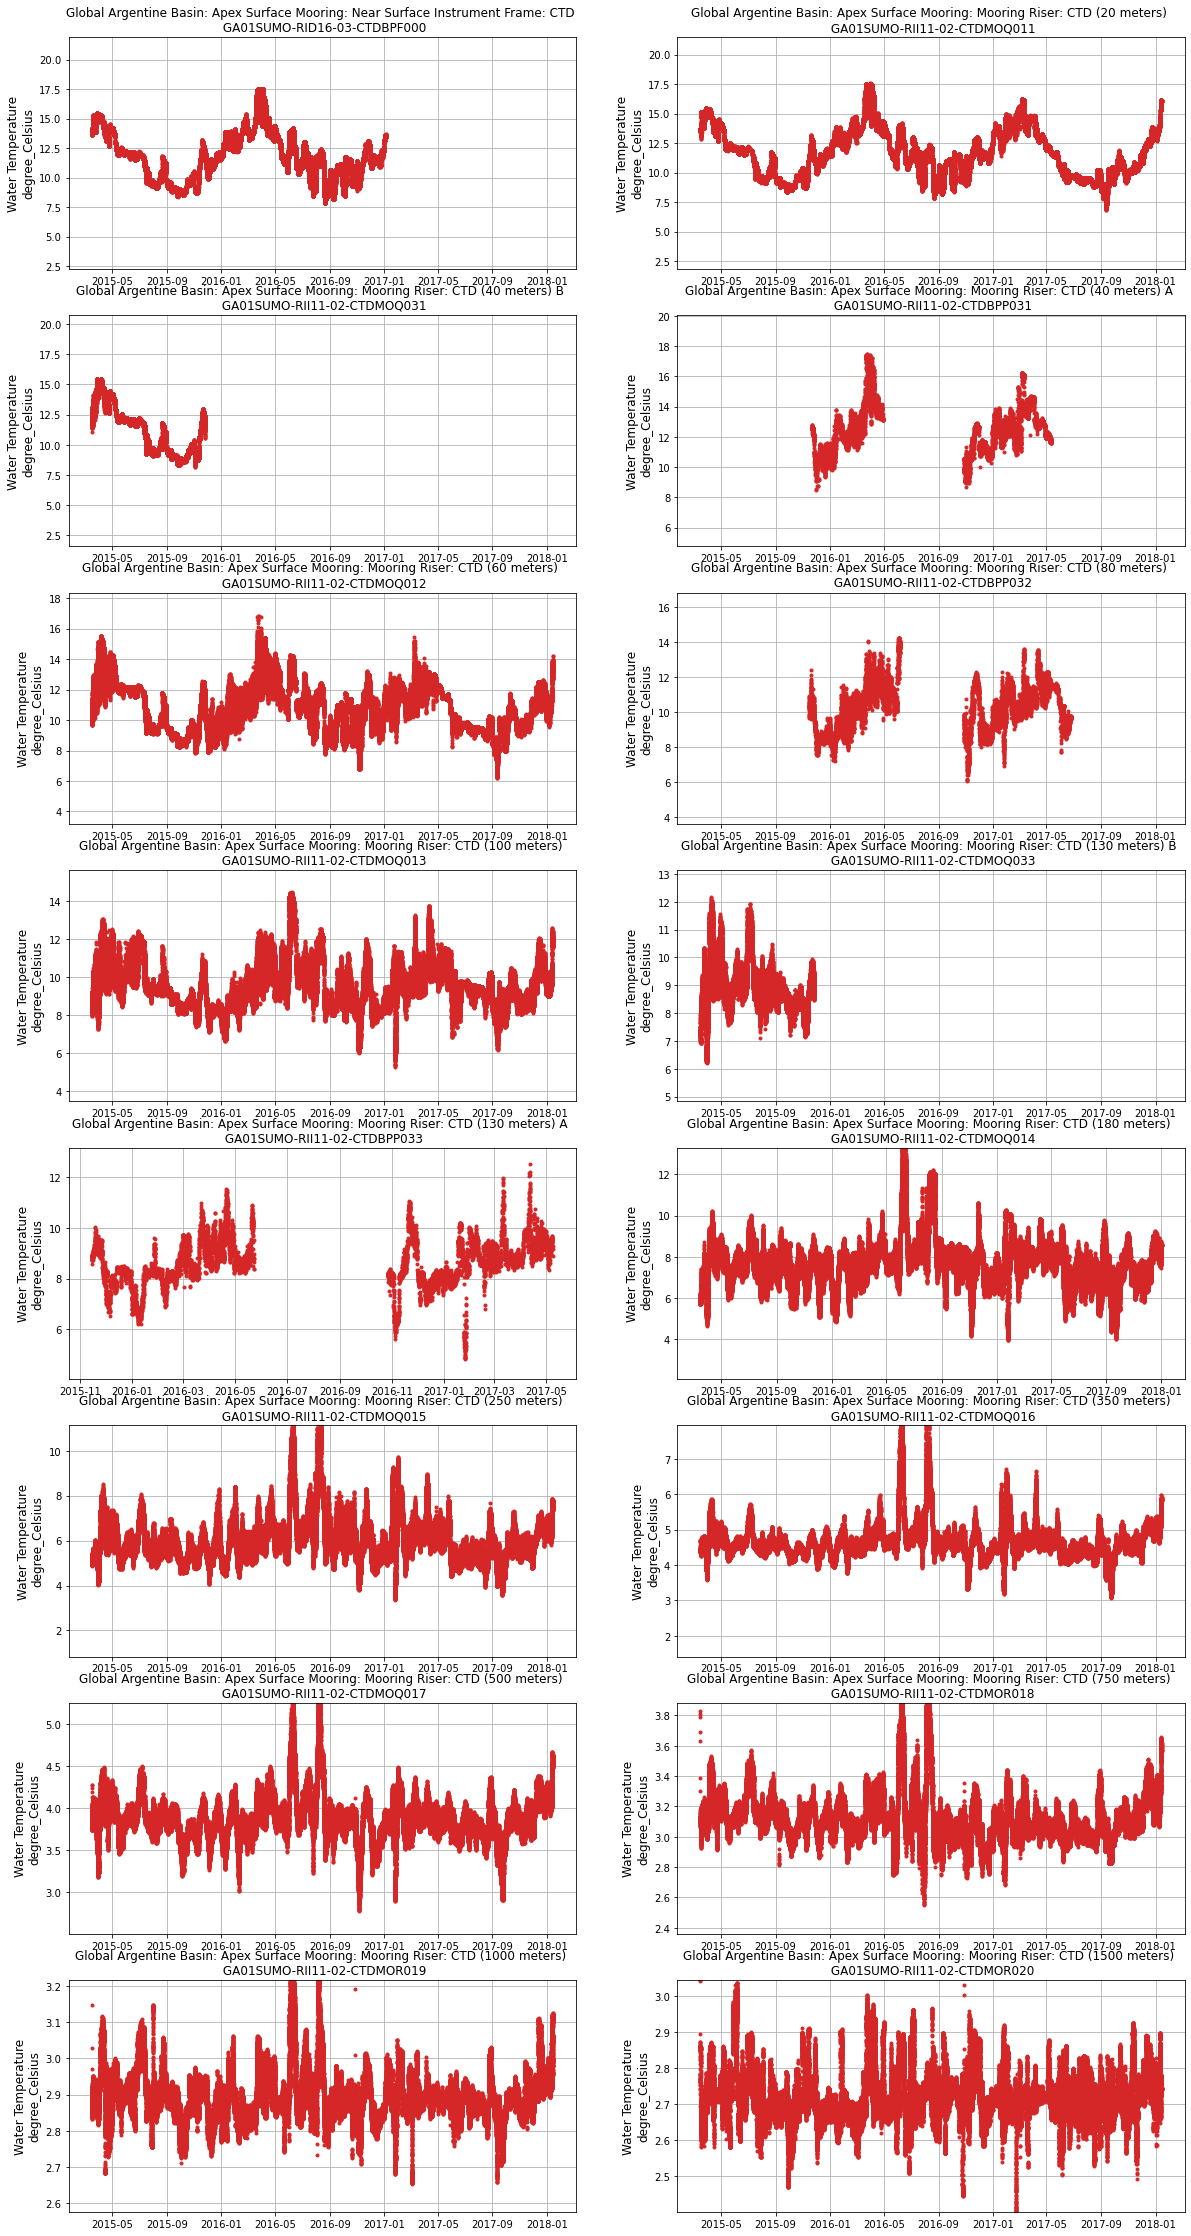

In [16]:
param = "sea_water_temperature"
color = "tab:red"
nfigs = len(ga01sumo.keys())
xmin, xmax = None, None
# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(nrows=int(np.ceil(nfigs/2)), ncols=2, figsize=(20, 5*nrows))

for k, refdes in enumerate(ga01sumo.keys()):
    row, col = int(np.floor(k/2)), int(k % 2)
    data = ga01sumo.get(refdes)
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    ax[row, col].plot(data["time"], data[param], marker=".", linestyle="", color=color)
    ax[row, col].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=12)
    ax[row, col].set_title(data.attrs["title"] + " \n " + refdes)
    ax[row, col].set_ylim(ymin, ymax)
    ax[row, col].grid()
    xmin_k, xmax_k = ax[row, col].get_xlim()
    if xmin is None or xmin_k < xmin:
        xmin = xmin_k
    if xmax is None or xmax_k > xmax:
        xmax = xmax_k
    
# Set uniform xgrid
for k in np.arange(0, len(ax), 1):
    row, col = int(np.floor(k/2)), int(k % 2)
    ax[row, col].set_xlim(xmin, xmax)
    
#fig.autofmt_xdate()

In [17]:
np.ceil(nfigs/2)

8.0

In [18]:
saveDir = "../results/figures"
figName = "_".join(("GA01SUMO", "all", "ctds", param))
fig.savefig(f"{saveDir}/{figName}.png")

Plot all of the timeseries on top of each other, using different colors to denote different instruments

In [19]:
import matplotlib

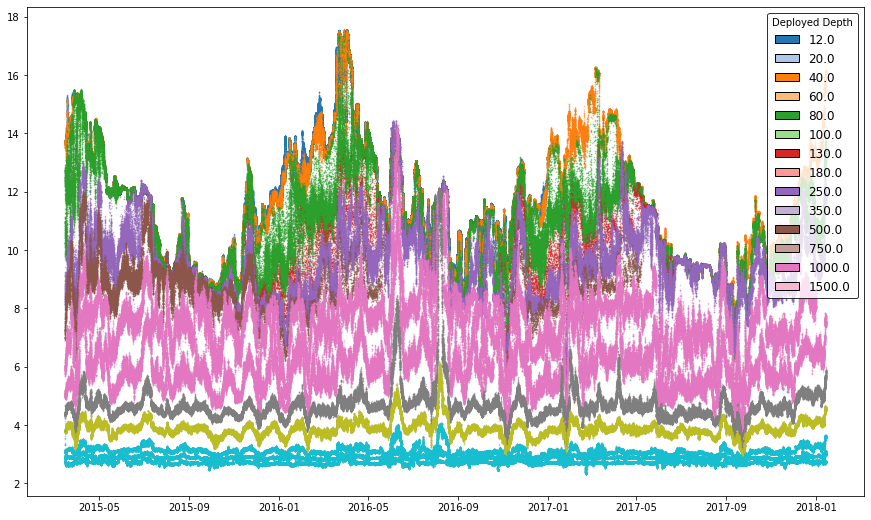

In [20]:
param = "sea_water_temperature"

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))

# Set discrete category values
levels, categories = pd.factorize(ga01sumo_datasets['depth'])
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab20(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")
    
# Plot the data
for k, refdes in enumerate(ga01sumo.keys()):
    # Assign the category based on depth
    depth = int(ga01sumo_datasets[ga01sumo_datasets["refdes"] == refdes]["depth"])
    color = colors[list(categories).index(depth)]
    data = ga01sumo.get(refdes)
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    ax.plot(data["time"], data[param], marker=".", linestyle="", markersize=1, color=color, alpha=0.5)

ax.legend(handles=handles, title='Deployed Depth', fontsize=12, edgecolor="black")

#### GA03FLMA

In [21]:
ga03flma = dict.fromkeys(ga03flma_datasets["refdes"])
for refdes in ga03flma_datasets["refdes"]:
    datasets = pd.read_csv(erd.get_search_url(search_for=refdes.lower(), response="csv"))["Dataset ID"]
    dset = datasets.iloc[0]
    erd.dataset_id = dset
    data = erd.to_xarray()
    data = data.swap_dims({"obs":"time"})
    ga03flma[refdes] = data

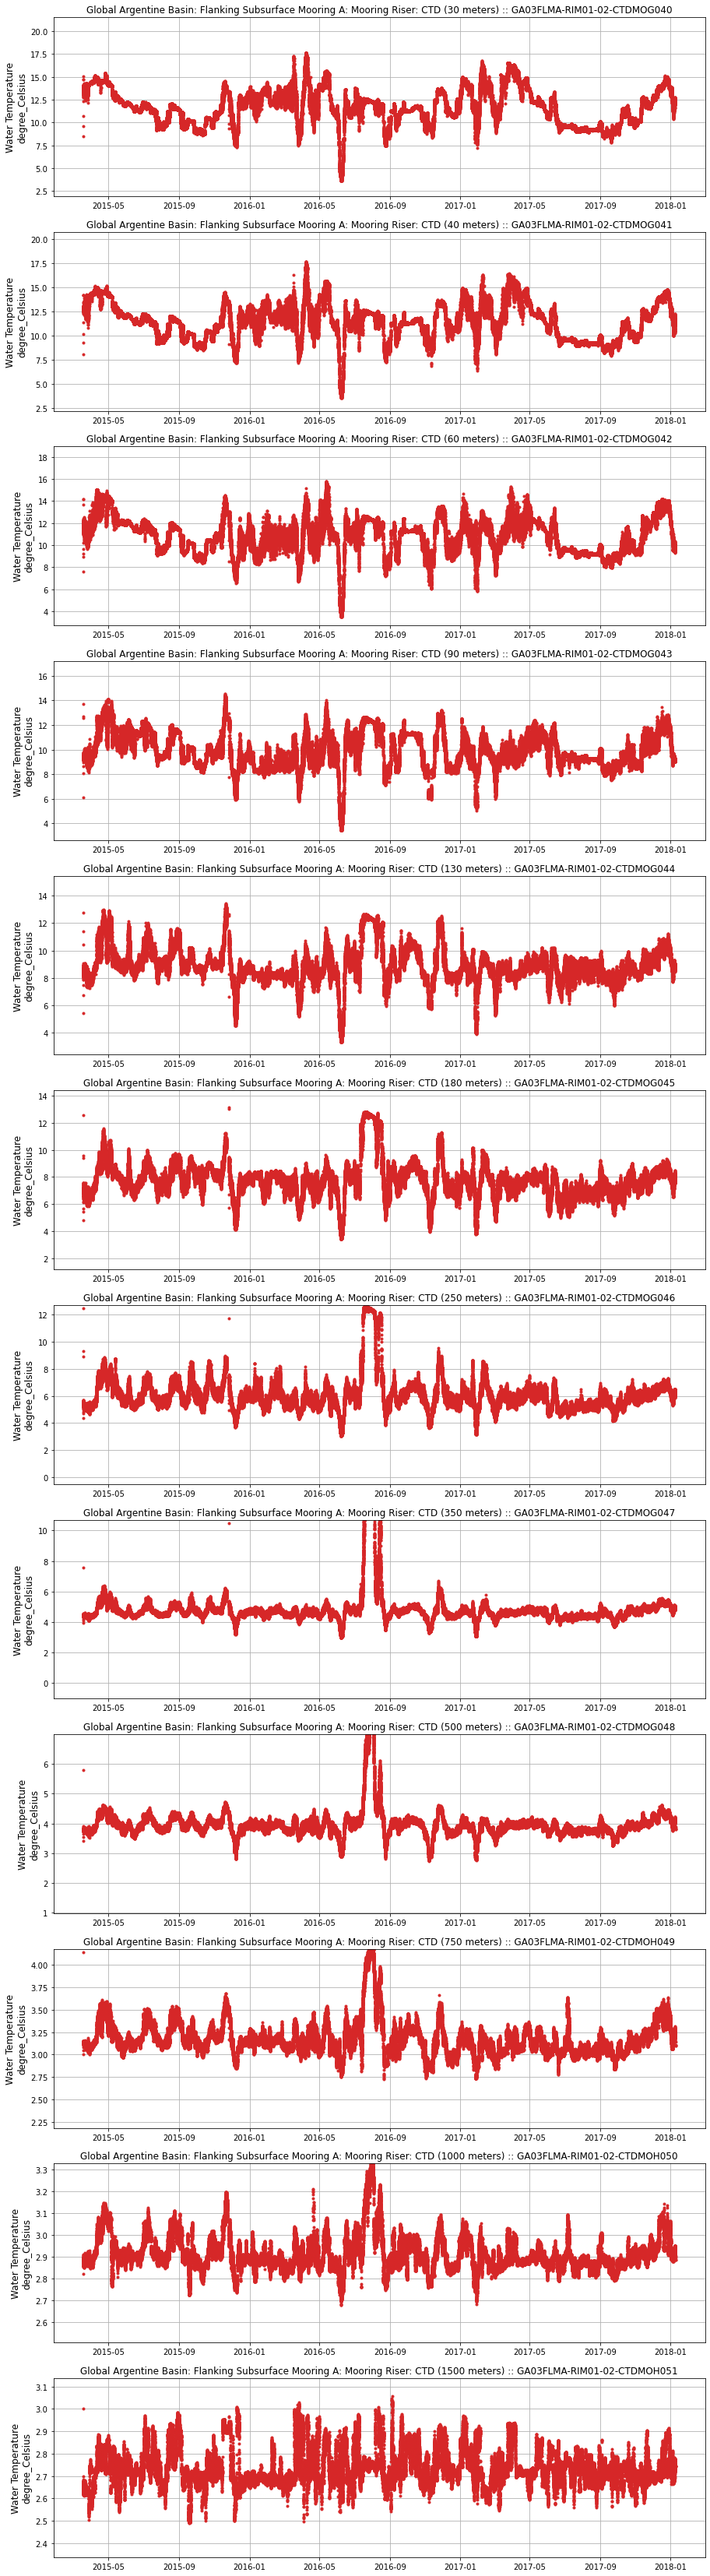

In [22]:
param = "sea_water_temperature"
color = "tab:red"
nrows = len(ga03flma.keys())
xmin, xmax = None, None
# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 5*nrows))

for k, refdes in enumerate(ga03flma.keys()):
    data = ga03flma.get(refdes)
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    ax[k].plot(data["time"], data[param], marker=".", linestyle="", color=color)
    ax[k].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=12)
    ax[k].set_title(data.attrs["title"] + " :: " + refdes)
    ax[k].set_ylim(ymin, ymax)
    ax[k].grid()
    xmin_k, xmax_k = ax[k].get_xlim()
    if xmin is None or xmin_k < xmin:
        xmin = xmin_k
    if xmax is None or xmax_k > xmax:
        xmax = xmax_k
    
# Set uniform xgrid
for k in np.arange(0, len(ax), 1):
    ax[k].set_xlim(xmin, xmax)

In [23]:
saveDir = "../results/figures"
figName = "_".join(("GA03FLMA", "all", "ctds", param))
fig.savefig(f"{saveDir}/{figName}.png")

Plot a specific reference designator

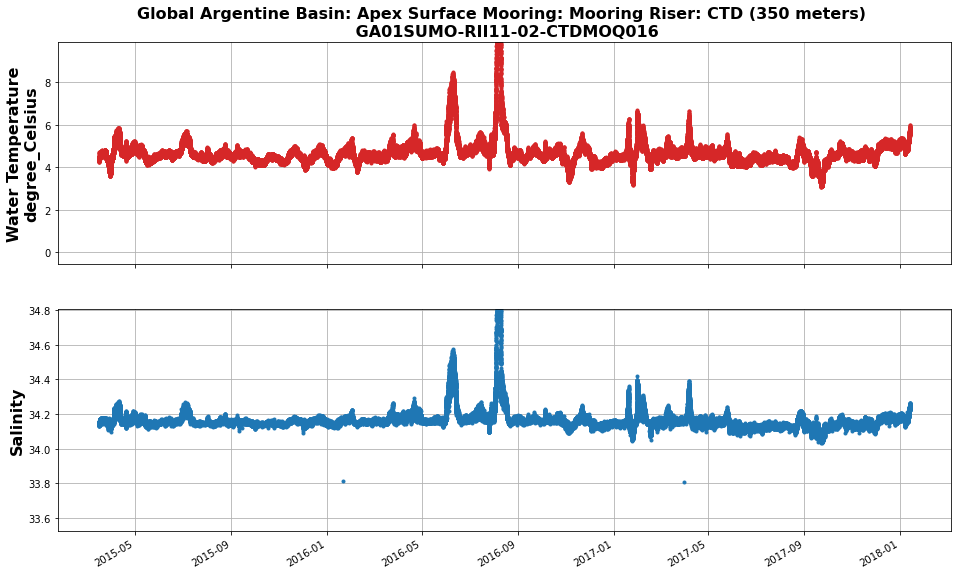

In [24]:
refdes = "GA01SUMO-RII11-02-CTDMOQ016"
data = ga01sumo.get(refdes)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,10))

# Plot sea_water_temperature
param = "sea_water_temperature"
color = "tab:red"

yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
ymin, ymax = yavg-8*ystd, yavg+8*ystd

ax[0].plot(data["time"], data[param], marker=".", linestyle="", color=color)
ax[0].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=16, weight="bold")
ax[0].set_ylim(ymin, ymax)
ax[0].grid()
ax[0].set_title(data.attrs["title"] + " \n " + refdes, fontsize=16, weight="bold")

# Plot the practical salinity
param = "sea_water_practical_salinity"
color = "tab:blue"

yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
ymin, ymax = yavg-8*ystd, yavg+8*ystd

ax[1].plot(data["time"], data[param], marker=".", linestyle="", color=color)
ax[1].set_ylabel(data[param].attrs["long_name"], fontsize=16, weight="bold")
ax[1].set_ylim(ymin, ymax)
ax[1].grid()

fig.autofmt_xdate()

In [25]:
fig.savefig(f"../results/figures/{refdes}_temperature_salinity.png", facecolor="white", transparent=False)

#### GA03FLMB

In [26]:
ga03flmb = dict.fromkeys(ga03flmb_datasets["refdes"])
for refdes in ga03flmb_datasets["refdes"]:
    datasets = pd.read_csv(erd.get_search_url(search_for=refdes.lower(), response="csv"))["Dataset ID"]
    dset = datasets.iloc[0]
    erd.dataset_id = dset
    data = erd.to_xarray()
    data = data.swap_dims({"obs":"time"})
    ga03flmb[refdes] = data

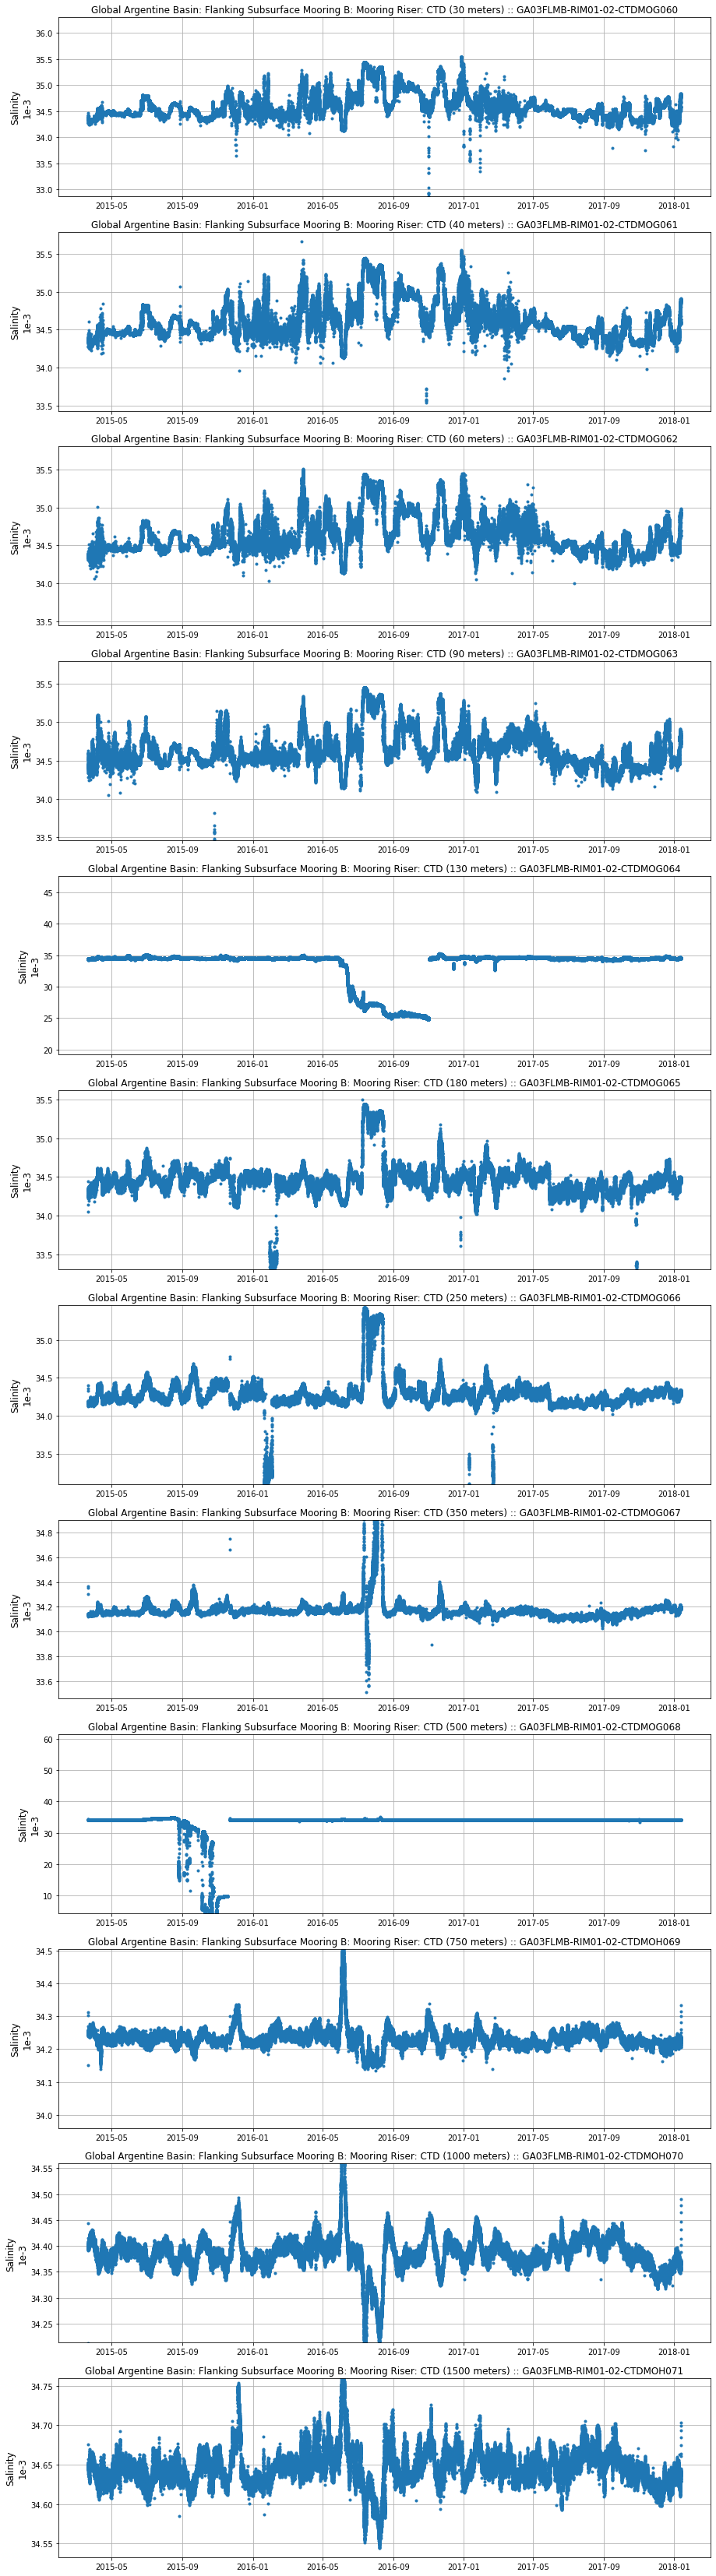

In [27]:
param = "sea_water_practical_salinity"
color = "tab:blue"
nrows = len(ga03flmb.keys())
xmin, xmax = None, None
# Plot the seawater temperature data for all of the ga01sumo datasets
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(15, 5*nrows))

for k, refdes in enumerate(ga03flmb.keys()):
    data = ga03flmb.get(refdes)
    yavg, ystd = data[param].mean(skipna=True), data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    ax[k].plot(data["time"], data[param], marker=".", linestyle="", color=color)
    ax[k].set_ylabel(data[param].attrs["long_name"] + "\n" + data[param].attrs["units"], fontsize=12)
    ax[k].set_title(data.attrs["title"] + " :: " + refdes)
    ax[k].set_ylim(ymin, ymax)
    ax[k].grid()
    xmin_k, xmax_k = ax[k].get_xlim()
    if xmin is None or xmin_k < xmin:
        xmin = xmin_k
    if xmax is None or xmax_k > xmax:
        xmax = xmax_k
    
# Set uniform xgrid
for k in np.arange(0, len(ax), 1):
    ax[k].set_xlim(xmin, xmax)

In [28]:
saveDir = "../results/figures"
figName = "_".join(("GA03FLMB", "all", "ctds", param))
fig.savefig(f"{saveDir}/{figName}.png")

Plot a particular parameter (data variable) for all the given CTDs at a particular depth across all moorings in an array

In [29]:
param = "sea_water_temperature"
#param = "sea_water_practical_salinity"

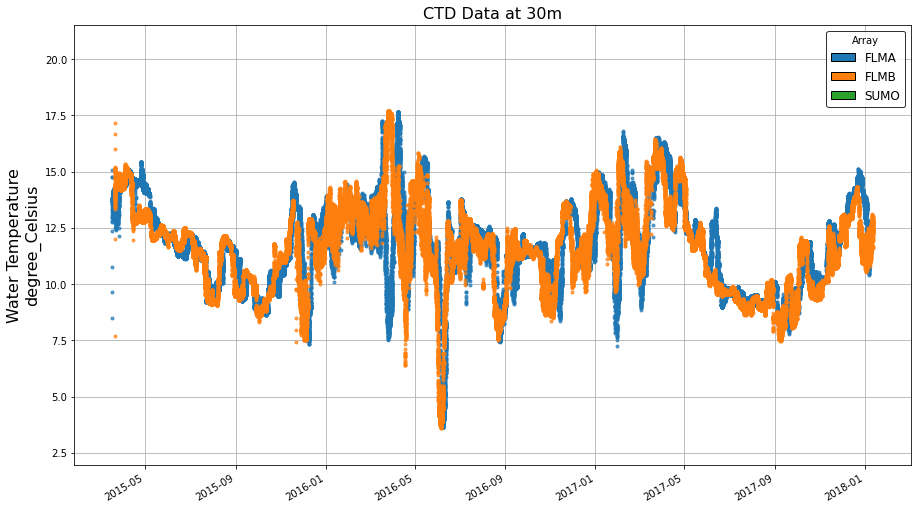

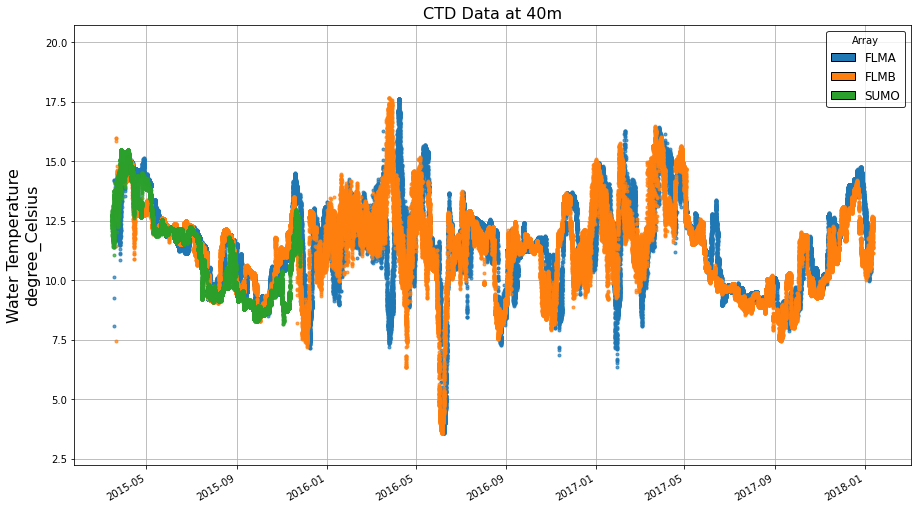

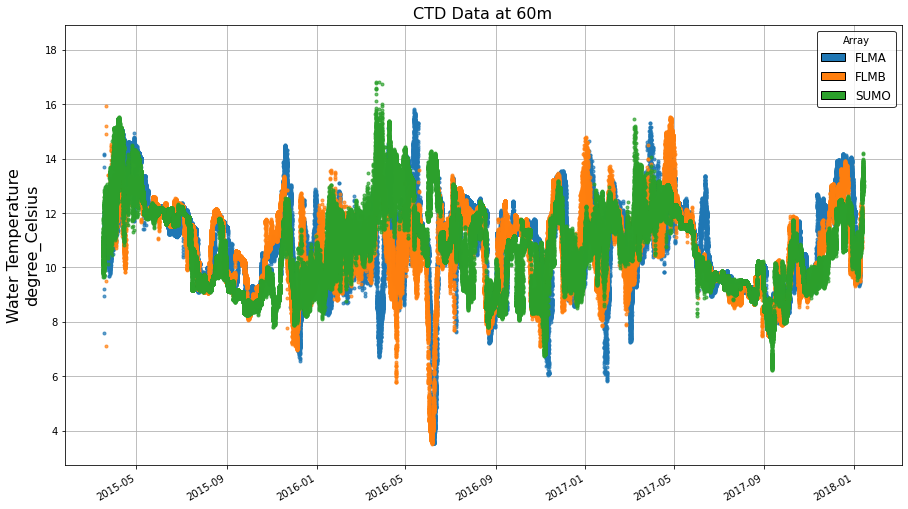

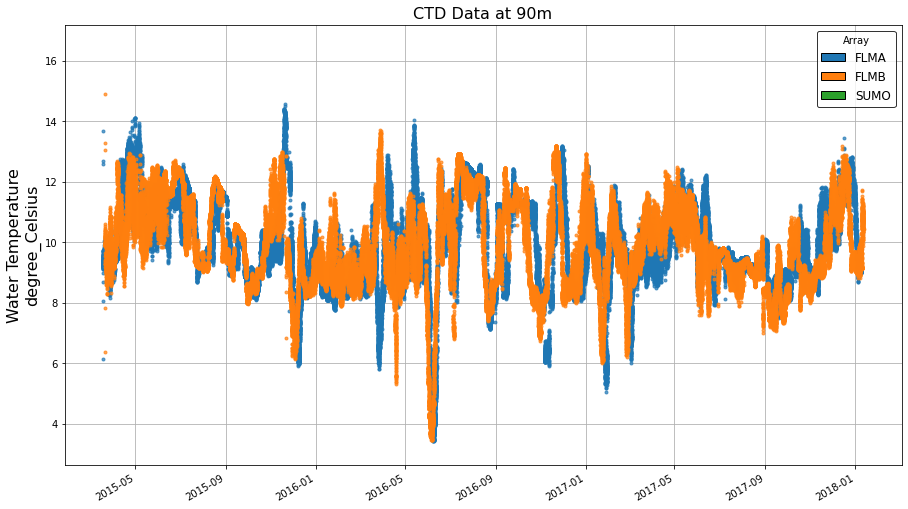

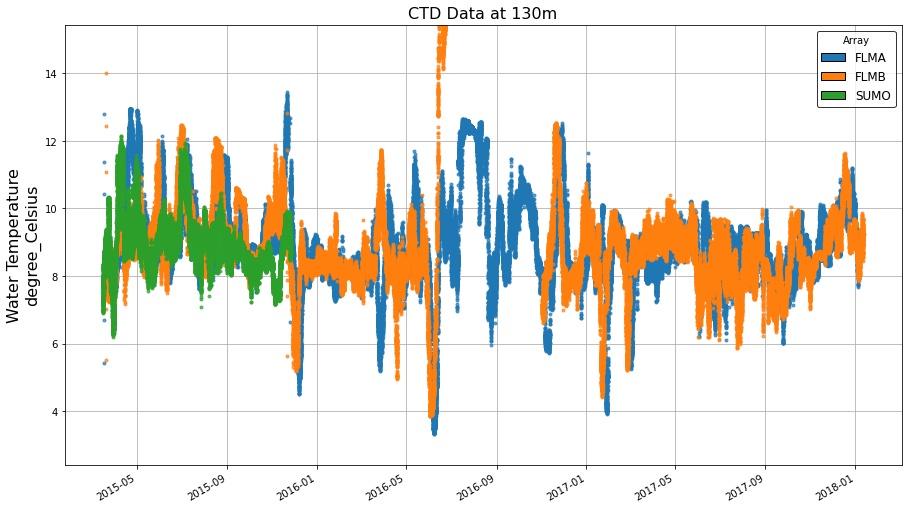

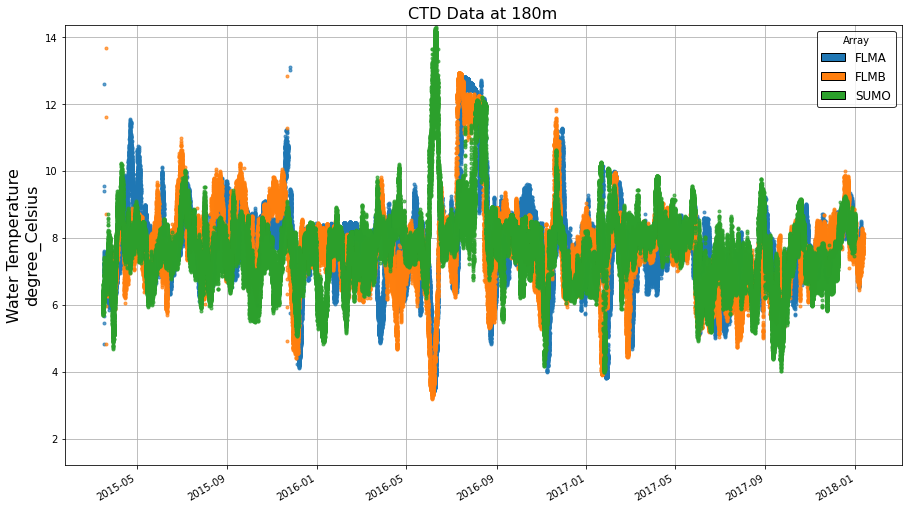

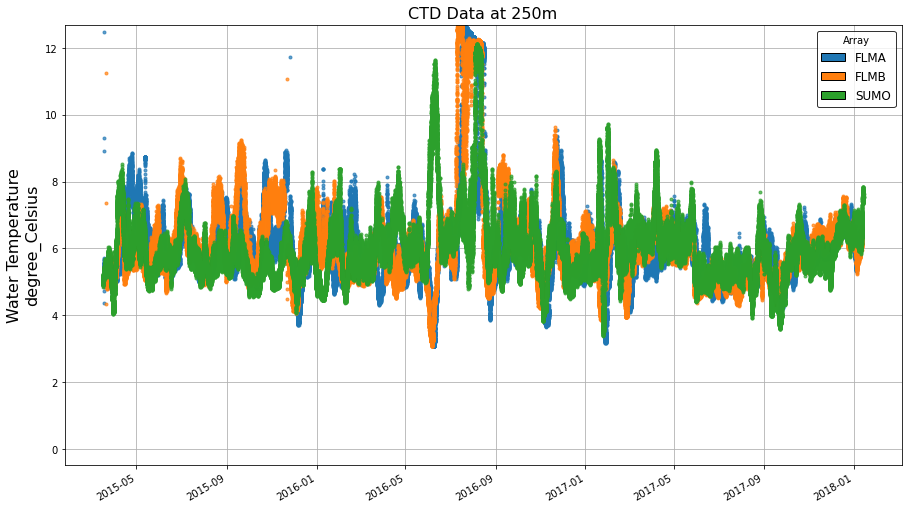

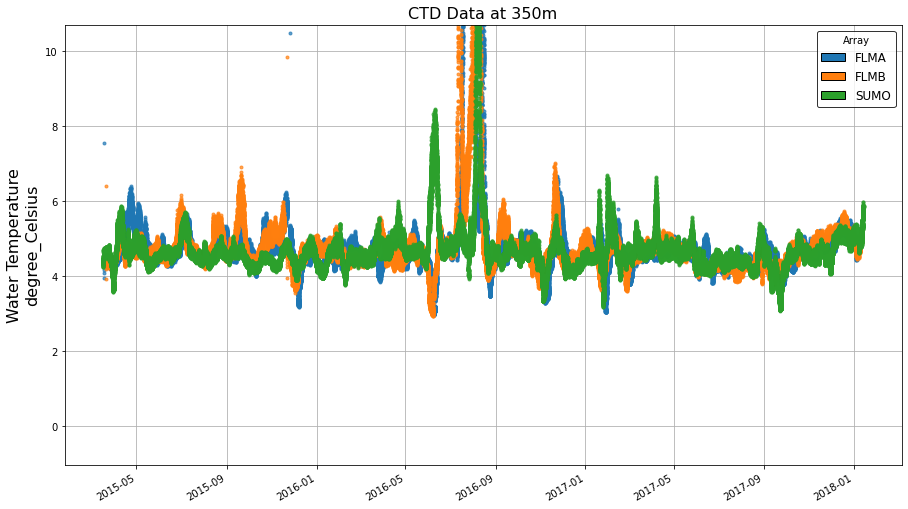

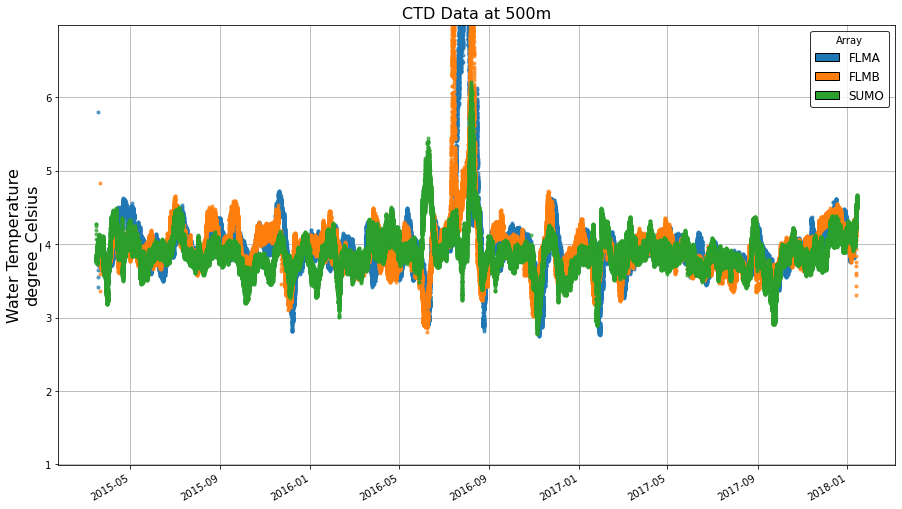

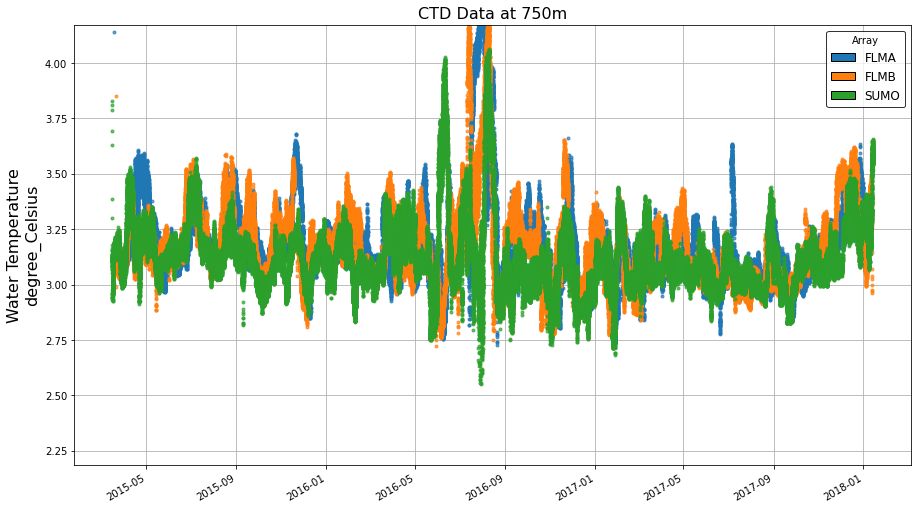

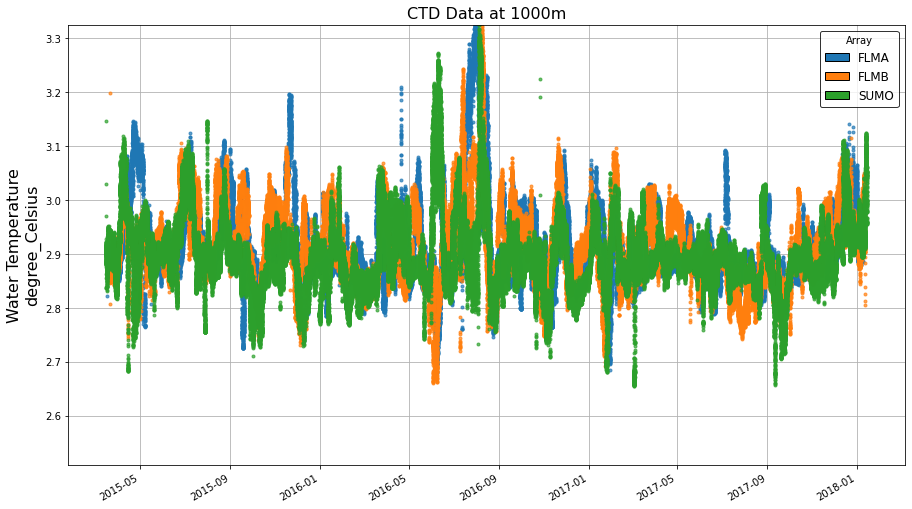

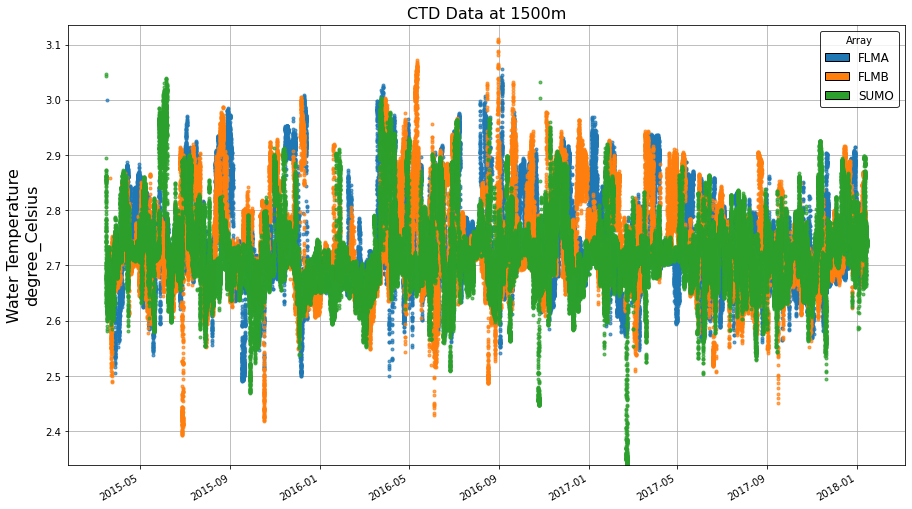

In [30]:
# Set the colors
arrays = ["FLMA", "FLMB", "SUMO"]
levels, categories = pd.factorize(arrays)
colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
handles = [matplotlib.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
for h in handles:
    h.set_edgecolor("black")

# Plot the data 
for depth in ga03flma_datasets["depth"]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 9))

    # ----------------------------------------------------------
    # Flanking Mooring A
    flma = ga03flma_datasets[ga03flma_datasets["depth"] == depth]["refdes"].values[0]
    flma_data = ga03flma.get(flma)
    # Plot the flma data
    ax.plot(flma_data["time"], flma_data[param], linestyle="", marker=".", color=colors[0], alpha=0.7)
    yavg, ystd = flma_data[param].mean(skipna=True), flma_data[param].std(skipna=True)
    ymin, ymax = yavg-5*ystd, yavg+5*ystd
    
    # ----------------------------------------------------------
    # Flanking Mooring B
    flmb = ga03flmb_datasets[ga03flmb_datasets["depth"] == depth]["refdes"].values[0]
    flmb_data = ga03flmb.get(flmb)
    # Plot the flma data
    ax.plot(flmb_data["time"], flmb_data[param], linestyle="", marker=".", color=colors[1], alpha=0.7)
    
    # ----------------------------------------------------------
    # Surface Mooring
    try:
        sumo = ga01sumo_datasets[ga01sumo_datasets["depth"] == depth]["refdes"].values[0]
        sumo_data = ga01sumo.get(sumo)
        # Plot the flma data
        ax.plot(sumo_data["time"], sumo_data[param], linestyle="", marker=".", color=colors[2], alpha=0.7)
    except:
        sumo = None
        
    # ----------------------------------------------------------
    # Set the figure
    ax.grid()
    ax.set_ylabel(flma_data[param].attrs["long_name"] + "\n" + flma_data[param].attrs["units"], fontsize=16)
    #if depth >= 500:
    ax.set_ylim(ymin, ymax)
    ax.legend(handles=handles, title='Array', fontsize=12, edgecolor="black")
    ax.set_title(f"CTD Data at {int(depth)}m", fontsize=16)
    fig.autofmt_xdate()

In [31]:
saveDir = "../results/figures"
figName = "_".join((refdes, "time", "series"))
fig.savefig(f"{saveDir}/{figName}.png")

### Add Deployment Information
Datasets downloaded from Data Explorer do not come with the deployment information as a data variable, unlike datasets downloaded from the OOI Data Portal (ooinet.oceanobservatories.org). Here, we step through adding deployment information to the ERDDAP dataset by requesting the deployment times from the Data Portal via the OOI API.

In [33]:
for refdes in ga01sumo:
    # Get the deployment info for the given reference designator
    deployments = OOINet.get_deployments(refdes)
    
    # Get the dataset
    data = ga01sumo.get(refdes)

    # Add the deployment info to the dataset
    d = xr.DataArray(data=np.zeros, dims=data["time"].dims, coords=data["time"].coords, name="deployment")
    for depNum in sorted(deployments["deploymentNumber"]):
        # Get the start and end times of the deployments
        deployStart = deployments[deployments["deploymentNumber"] == depNum]["deployStart"].values[0]
        deployEnd = deployments[deployments["deploymentNumber"] == depNum]["deployEnd"].values[0]
        # Add in the deployment number
        d[(d.time >= deployStart) & (d.time <= deployEnd)] = depNum
        
    data[d.name] = d

In [34]:
for refdes in ga03flma:
    # Get the deployment info for the given reference designator
    deployments = OOINet.get_deployments(refdes)
    
    # Get the dataset
    data = ga03flma.get(refdes)

    # Add the deployment info to the dataset
    d = xr.DataArray(data=np.zeros, dims=data["time"].dims, coords=data["time"].coords, name="deployment")
    for depNum in sorted(deployments["deploymentNumber"]):
        # Get the start and end times of the deployments
        deployStart = deployments[deployments["deploymentNumber"] == depNum]["deployStart"].values[0]
        deployEnd = deployments[deployments["deploymentNumber"] == depNum]["deployEnd"].values[0]
        # Add in the deployment number
        d[(d.time >= deployStart) & (d.time <= deployEnd)] = depNum
        
    data[d.name] = d

In [35]:
for refdes in ga03flmb:
    # Get the deployment info for the given reference designator
    deployments = OOINet.get_deployments(refdes)
    
    # Get the dataset
    data = ga03flmb.get(refdes)

    # Add the deployment info to the dataset
    d = xr.DataArray(data=np.zeros, dims=data["time"].dims, coords=data["time"].coords, name="deployment")
    for depNum in sorted(deployments["deploymentNumber"]):
        # Get the start and end times of the deployments
        deployStart = deployments[deployments["deploymentNumber"] == depNum]["deployStart"].values[0]
        deployEnd = deployments[deployments["deploymentNumber"] == depNum]["deployEnd"].values[0]
        # Add in the deployment number
        d[(d.time >= deployStart) & (d.time <= deployEnd)] = depNum
        
    data[d.name] = d

## Select a single Data set to examine

In [36]:
ga03flma.keys()

dict_keys(['GA03FLMA-RIM01-02-CTDMOG040', 'GA03FLMA-RIM01-02-CTDMOG041', 'GA03FLMA-RIM01-02-CTDMOG042', 'GA03FLMA-RIM01-02-CTDMOG043', 'GA03FLMA-RIM01-02-CTDMOG044', 'GA03FLMA-RIM01-02-CTDMOG045', 'GA03FLMA-RIM01-02-CTDMOG046', 'GA03FLMA-RIM01-02-CTDMOG047', 'GA03FLMA-RIM01-02-CTDMOG048', 'GA03FLMA-RIM01-02-CTDMOH049', 'GA03FLMA-RIM01-02-CTDMOH050', 'GA03FLMA-RIM01-02-CTDMOH051'])

In [37]:
refdes = "GA03FLMA-RIM01-02-CTDMOG047"
data = ga03flma.get(refdes)

In [38]:
ga03flma.get(refdes)

<xarray.Dataset>
Dimensions:                                     (timeseries: 1, time: 98412)
Coordinates:
    latitude                                    (timeseries) float64 ...
    longitude                                   (timeseries) float64 ...
  * time                                        (time) datetime64[ns] 2015-03...
Dimensions without coordinates: timeseries
Data variables: (12/19)
    station                                     (timeseries) object ...
    rowSize                                     (timeseries) int32 ...
    z                                           (time) float64 ...
    sea_water_electrical_conductivity           (time) float64 ...
    sea_water_electrical_conductivity_qc_agg    (time) float64 ...
    sea_water_electrical_conductivity_qc_tests  (time) float64 ...
    ...                                          ...
    sea_water_pressure_qc_agg                   (time) float64 ...
    sea_water_pressure_qc_tests                 (time) float64 ...
    sea_water_temperature                       (time) float64 10.87 ... 4.893
    sea_water_temperature_qc_agg                (time) float64 ...
    sea_water_temperature_qc_tests              (time) float64 ...
    deployment                                  (time) object 1 1 1 1 ... 3 3 3
Attributes: (12/50)
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    contributor_role:              processor
    contributor_role_vocabulary:   NERC
    ...                            ...
    station_id:                    104030.0
    summary:                       Timeseries data from 'Global Argentine Bas...
    time_coverage_end:             2018-01-09T10:45:00Z
    time_coverage_start:           2015-03-17T19:45:00Z
    title:                         Global Argentine Basin: Flanking Subsurfac...
    Westernmost_Easting:           -42.880193

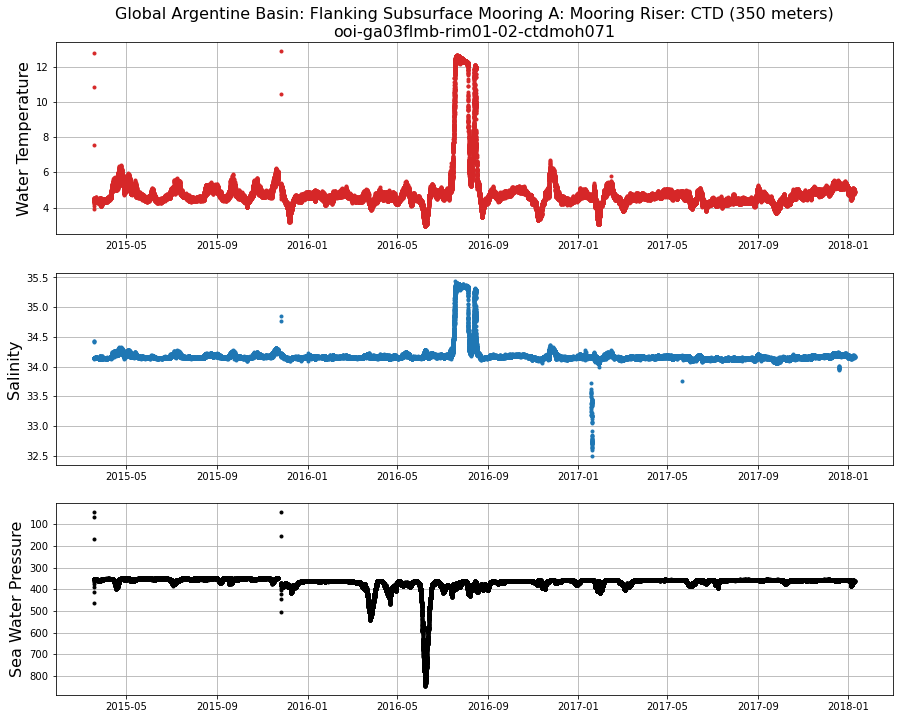

In [39]:
# Quick print of the CTD data
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

# Plot the temperature data
avg, std = data.sea_water_temperature.mean(), data.sea_water_temperature.std()
ymin, ymax = avg-5*std, avg+5*std
ax0.plot(data.time, data.sea_water_temperature, marker=".", linestyle="", color="tab:red")
ax0.grid()
ax0.set_ylabel(data.sea_water_temperature.attrs["long_name"], fontsize=16)
#ax0.set_ylim((ymin, ymax))
#ax0.set_xlim((pd.to_datetime("2016-07-15"),pd.to_datetime("2016-08-17")))
ax0.set_title(data.attrs["title"] + "\n" + dset, fontsize=16)

# Plot the salinity data
avg, std = data.sea_water_practical_salinity.mean(), data.sea_water_practical_salinity.std()
ymin, ymax = avg-5*std, avg+5*std
ax1.plot(data.time, data.sea_water_practical_salinity, marker=".", linestyle="", color="tab:blue")
ax1.grid()
ax1.set_ylabel(data.sea_water_practical_salinity.attrs["long_name"], fontsize=16)
#ax1.set_ylim((ymin, ymax))
#ax1.set_xlim((pd.to_datetime("2016-07-15"),pd.to_datetime("2016-08-17")))


# Plot the pressure data
avg, std = data.sea_water_pressure.mean(), data.sea_water_pressure.std()
ymin, ymax = avg-5*std, avg+5*std
ax2.plot(data.time, data.sea_water_pressure, marker=".", linestyle="", color="black")
ax2.grid()
ax2.set_ylabel(data.sea_water_pressure.attrs["long_name"], fontsize=16)
#ax2.set_ylim((ymin, ymax))
#ax2.set_xlim((pd.to_datetime("2016-07-15"),pd.to_datetime("2016-08-17")))

ax2.invert_yaxis()

### Clean up dataset
Before we go any farther, going to clean up the downloaded data set. First, going to dump all the passed "qc_tests" in the dataset. We're doing this in order to be able to see for ourselves how these are calculated

In [40]:
for var in data.variables:
    if "qc" in var:
        data = data.drop(var)

## Calculate Gross Range
First, calculate the gross range of the time series with respect to the salinity and temperature

In [41]:
from qartod.gross_range import GrossRange
from qartod.climatology import Climatology
from ioos_qc.config import QcConfig, ContextConfig, Config
from ioos_qc.qartod import gross_range_test, climatology_test, ClimatologyConfig

In [42]:
# Parameters and tests to run
parameters = ["sea_water_practical_salinity", "sea_water_temperature"]
tests = ["gross_range", "climatology"]

# Dictionary object to store output results
results = dict.fromkeys(parameters)
for key in results.keys():
    results[key] = dict.fromkeys(tests, {})

In [43]:
results

{'sea_water_practical_salinity': {'gross_range': {}, 'climatology': {}},
 'sea_water_temperature': {'gross_range': {}, 'climatology': {}}}

In [44]:
def add_qartod_test(data, param, test, test_results):
    # Generate the test name
    testName = "_".join((param, "qartod", test))
    
    # Create an xarray DataArray of the test_results
    test_results = xr.DataArray(
        data=test_results,
        dims=data[param].dims,
        coords=data[param].coords,
    )
    
    data[testName] = test_results
    return data

In [45]:
def aggregate_results(data, param):
    """Aggregate the results of all qartod tests for a given parameter"""
    # Get the qartod variables
    qartod_vars = []
    for var in data:
        if (param in var) & ("qartod" in var):
            qartod_vars.append(var)
            
    # Aggregate and take max flag
    aggregate = np.vstack((data[v] for v in qartod_vars))
    aggregate = aggregate.max(axis=0)
    return aggregate

In [46]:
for param in parameters:
    if param == "sea_water_temperature":
        fail_span = (-5, 35)
    elif param == "sea_water_practical_salinity":
        fail_span = (0, 42)
    else:
        raise TypeError(f"Param {param} not found.")
    # Iterate through the tests
    for test in tests:
        if test == "gross_range":
            # Calculate the gross range ranges
            fail_min, fail_max = fail_span
            gross_range = GrossRange(fail_min, fail_max)
            gross_range.fit(data, param)
            # Run the gross range test
            test_results = gross_range_test(
                inp=data[param],
                fail_span=(gross_range.fail_min, gross_range.fail_max),
                suspect_span=(gross_range.suspect_min, gross_range.suspect_max)
            )
            # Save the fit results
            results[param][test] = gross_range
        elif test == "climatology":
            # Calculate the gross range ranges
            climatology = Climatology()
            climatology.fit(data, param, fail_span=fail_span)
            # Make the climatology config objecty
            c = ClimatologyConfig()
            for ind in climatology.monthly_fit.index:
                vmin = np.floor((climatology.monthly_fit.loc[ind] - 2*climatology.monthly_std.loc[ind])*100)/100
                vmax = np.ceil((climatology.monthly_fit.loc[ind] + 2*climatology.monthly_std.loc[ind])*100)/100
                c.add(tspan=[ind, ind],
                      vspan=[vmin, vmax],
                      fspan=[fail_span[0], fail_span[1]],
                      zspan=[0,5000],
                      period="month")
            # Run the climatology test
            test_results = climatology_test(c,
                               inp=data[param],
                               tinp=data["time"],
                               zinp=data["sea_water_pressure"]
                              )
            # Save the fit results
            results[param][test] = climatology
        else:
            print(f"Error with test {test} for param {param}")
        # Save the results
        data = add_qartod_test(data, param, test, test_results)
    
    # Now add the aggregate flag for the given parameter
    aggregate = aggregate_results(data, param)
    data = add_qartod_test(data, param, "aggregate", aggregate)

In [47]:
results

{'sea_water_practical_salinity': {'gross_range': <qartod.gross_range.GrossRange at 0x7f1bab1b3f40>,
  'climatology': <qartod.climatology.Climatology at 0x7f1baace20a0>},
 'sea_water_temperature': {'gross_range': <qartod.gross_range.GrossRange at 0x7f1baac9a730>,
  'climatology': <qartod.climatology.Climatology at 0x7f1baad48520>}}

In [48]:
def plot_climatology(data, param, climatology, **kwargs):
    
    # Check the kwargs
    if "color" in kwargs.keys():
        color = kwargs.get("color")
    else:
        color = "tab:red"
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Plot the Observations
    ax.plot(data.time, data[param], marker=".", linestyle="", color=color, zorder=0, label="Observations")
    yavg, ystd = np.mean(data[param]), np.std(data[param])
    ymin, ymax = yavg-ystd*7, yavg+ystd*7
    ax.set_ylim((ymin, ymax))
    
    # Standard Deviation +/- 3
    for t in climatology.fitted_data.index:
        t0 = pd.Timestamp(year=t.year, month=t.month, day=1)
        mu = climatology.monthly_fit.loc[t.month]
        std = climatology.monthly_std.loc[t.month]
        ax.hlines(mu, t0, t, color="black", linewidth=3, label="Climatological Fit")
        ax.fill_between([t0, t], [mu+2*std, mu+2*std], [mu-2*std, mu-2*std], color=color, alpha=0.3, label="2*$\sigma$")

    
    # Add legend and labels
    handles, labels = ax.get_legend_handles_labels()[0][0:3], ax.get_legend_handles_labels()[1][0:3]
    ax.legend(handles, labels, fontsize=12)
    ax.set_title(data.attrs["platform_name"], fontsize=16, weight="bold")
    ax.set_ylabel(data[param].attrs["long_name"], fontsize=16, weight="bold")
    ax.grid()
    fig.autofmt_xdate()
    
    return fig, ax

In [49]:
#Plot the results
#data = ga03flma.get(refdes)


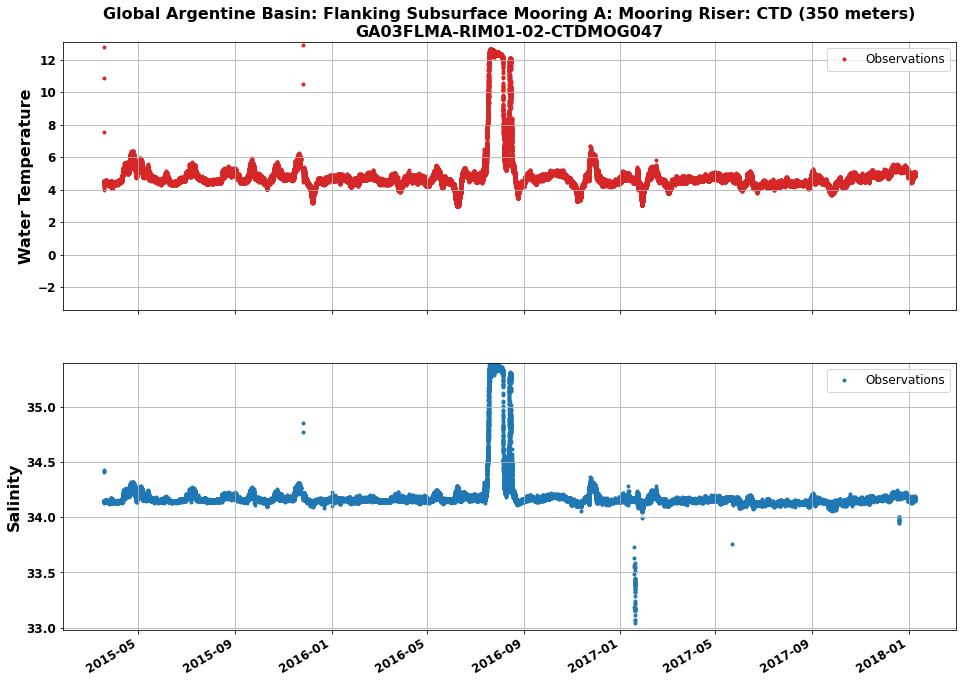

In [50]:
# Initialize the figure
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))

param = "sea_water_temperature"
color = "tab:red"

# Plot the Observations
ax[0].plot(data.time, data[param], marker=".", linestyle="", color=color, zorder=0, label="Observations")
yavg, ystd = np.mean(data[param]), np.std(data[param])
ymin, ymax = yavg-ystd*7, yavg+ystd*7
ax[0].set_ylim((ymin, ymax))

cdata = results[param]["climatology"]
# Standard Deviation +/- 3
#for t in cdata.fitted_data.index:
#    t0 = pd.Timestamp(year=t.year, month=t.month, day=1)
#    mu = cdata.monthly_fit.loc[t.month]
#    std = cdata.monthly_std.loc[t.month]
#    ax[0].hlines(mu, t0, t, color="black", linewidth=3, label="Climatological Fit")
#    ax[0].fill_between([t0, t], [mu+2*std, mu+2*std], [mu-2*std, mu-2*std], color=color, alpha=0.3, label="2*$\sigma$")


# Add legend and labels
handles, labels = ax[0].get_legend_handles_labels()[0][0:3], ax[0].get_legend_handles_labels()[1][0:3]
ax[0].legend(handles, labels, fontsize=12)
ax[0].set_title(data.attrs["platform_name"] + "\n" + refdes, fontsize=16, weight="bold")
ax[0].set_ylabel(data[param].attrs["long_name"], fontsize=16, weight="bold")
ax[0].grid()

for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")


param = "sea_water_practical_salinity"
color = "tab:blue"

# Plot the Observations
ax[1].plot(data.time, data[param], marker=".", linestyle="", color=color, zorder=0, label="Observations")
yavg, ystd = np.mean(data[param]), np.std(data[param])
ymin, ymax = yavg-ystd*7, yavg+ystd*7
ax[1].set_ylim((ymin, ymax))

cdata = results[param]["climatology"]
# Standard Deviation +/- 3
#for t in cdata.fitted_data.index:
#    t0 = pd.Timestamp(year=t.year, month=t.month, day=1)
#    mu = cdata.monthly_fit.loc[t.month]
#    std = cdata.monthly_std.loc[t.month]
#    ax[1].hlines(mu, t0, t, color="black", linewidth=3, label="Climatological Fit")
#    ax[1].fill_between([t0, t], [mu+2*std, mu+2*std], [mu-2*std, mu-2*std], color=color, alpha=0.3, label="2*$\sigma$")


# Add legend and labels
handles, labels = ax[1].get_legend_handles_labels()[0][0:3], ax[1].get_legend_handles_labels()[1][0:3]
ax[1].legend(handles, labels, fontsize=12)
ax[1].set_ylabel(data[param].attrs["long_name"], fontsize=16, weight="bold")
ax[1].grid()

fig.autofmt_xdate()

for tick in ax[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [51]:
refdes

'GA03FLMA-RIM01-02-CTDMOG047'

In [ ]:
fig.savefig(f"../results/figures/{refdes}_temp_sal.png", facecolor="white", transparent=False)

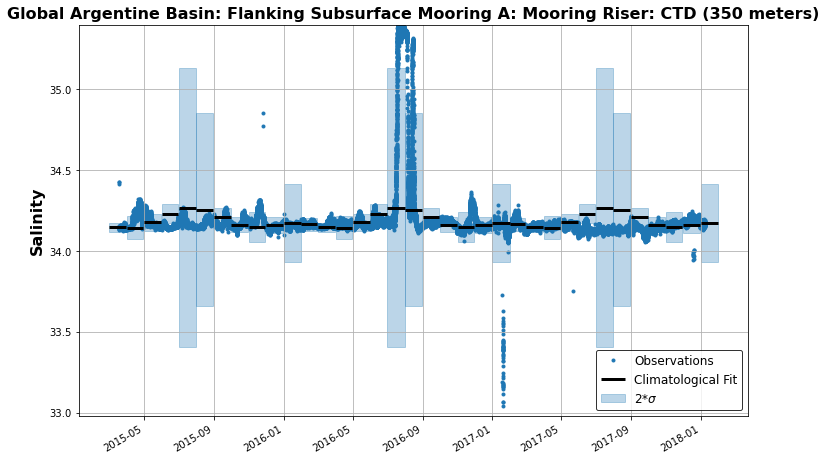

In [52]:
fig, ax = plot_climatology(data, param, results[param]["climatology"], color="tab:blue")
handles, labels = ax.get_legend_handles_labels()[0][0:3], ax.get_legend_handles_labels()[1][0:3]
ax.legend(handles, labels, fontsize=12, loc="lower right", edgecolor="black")

In [ ]:
figName = "_".join((refdes, param, test))
figName

In [ ]:
saveDir = "../results/figures/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)
fig.savefig(f"{saveDir}/{figName}.png", facecolor="white", transparent=False)

In [53]:
param = "sea_water_temperature"

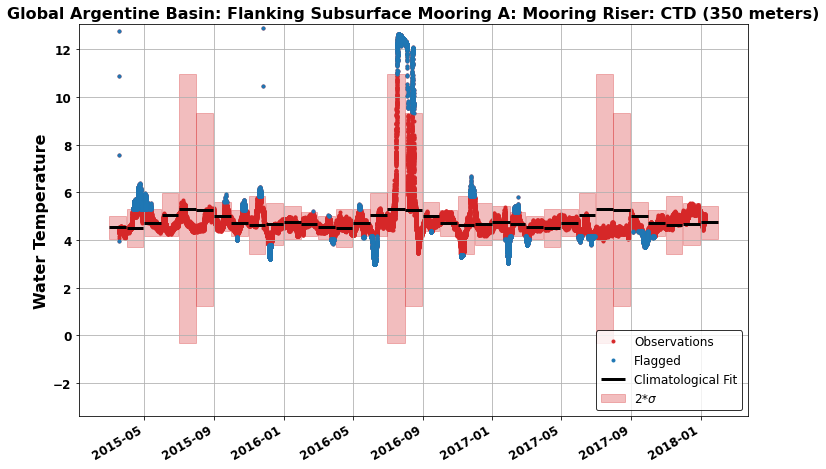

In [54]:
fig, ax = plot_climatology(data, param, results[param]["climatology"], color="tab:red")
#handles, labels = ax.get_legend_handles_labels()
#first_legend.set_bbox_to_anchor((1, 0.7))
#ax.add_artist(first_legend)
xmin, xmax = ax.get_xlim()

# Plot the flagged data
flagged_data = data.where((data.sea_water_temperature_qartod_climatology == 3), drop=True)
ax.plot(flagged_data.time, flagged_data.sea_water_temperature, linestyle="", marker=".", color="tab:blue", label="Flagged")
handles, labels = ax.get_legend_handles_labels()[0][0:4], ax.get_legend_handles_labels()[1][0:4]
ax.legend(handles, labels, fontsize=12, loc="lower right", edgecolor="black")


for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [ ]:
figName = "_".join((refdes, param, test, "with_flags"))
figName

In [ ]:
fig.savefig(f"{saveDir}/{figName}.png", facecolor="white", transparent=False)

Plot a histogram, by month, of the climatology-flagged data

In [55]:
param="sea_water_temperature"
climatology = results[param]["climatology"]

In [58]:
flags = (data.sea_water_temperature_qartod_climatology == 3).resample(time="M").sum()
flags

<xarray.DataArray 'sea_water_temperature_qartod_climatology' (time: 35)>
array([   4, 1091,  456,    0,    0,    0,   14,  254,  195,  334,    0,
          1,  112,    0,   51,  885, 1345,  697,   20,    0,  574,    0,
        416,  335,  280,    0,   16,  599,    0,    0, 1115,   58,    0,
          0,    0])
Coordinates:
  * time     (time) datetime64[ns] 2015-03-31 2015-04-30 ... 2018-01-31

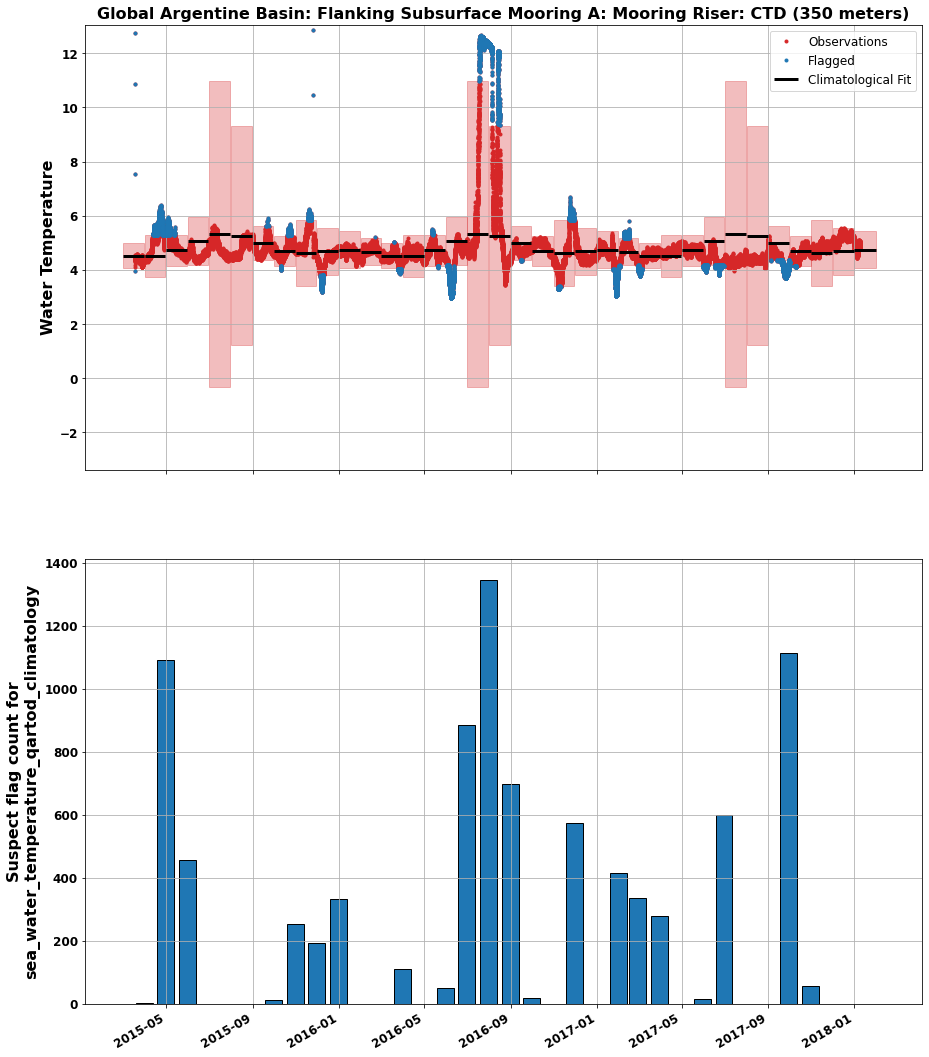

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 20), sharex=True)

# ------------------------------------------------
# Plot the first figure with the time series data
# Plot the Observations
ax[0].plot(data.time, data[param], marker=".", linestyle="", color="tab:red", zorder=0, label="Observations")
yavg, ystd = np.mean(data[param]), np.std(data[param])
ymin, ymax = yavg-ystd*7, yavg+ystd*7
ax[0].set_ylim((ymin, ymax))

# Standard Deviation +/- 3
for t in climatology.fitted_data.index:
    t0 = pd.Timestamp(year=t.year, month=t.month, day=1)
    mu = climatology.monthly_fit.loc[t.month]
    std = climatology.monthly_std.loc[t.month]
    ax[0].hlines(mu, t0, t, color="black", linewidth=3, label="Climatological Fit")
    ax[0].fill_between([t0, t], [mu+2*std, mu+2*std], [mu-2*std, mu-2*std], color="tab:red", alpha=0.3, label="2*$\sigma$")

# Plot the flagged data
flagged_data = data.where((data.sea_water_temperature_qartod_climatology == 3), drop=True)
ax[0].plot(flagged_data.time, flagged_data[param], linestyle="", marker=".", color="tab:blue", label="Flagged")
handles, labels = ax[0].get_legend_handles_labels()[0][0:4], ax[0].get_legend_handles_labels()[1][0:4]
ax[0].legend(handles, labels, fontsize=12, loc="lower right", edgecolor="black")

for tick in ax[0].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
# Add legend and labels
handles, labels = ax[0].get_legend_handles_labels()[0][0:3], ax[0].get_legend_handles_labels()[1][0:3]
ax[0].legend(handles, labels, fontsize=12)
ax[0].set_title(data.attrs["platform_name"], fontsize=16, weight="bold")
ax[0].set_ylabel(data[param].attrs["long_name"], fontsize=16, weight="bold")
ax[0].grid()
    
# -----------------------------------------------------
# Plot the histogram of the flags
ax[1].bar(flags.time, flags.values, width=24.0, edgecolor="k", color="tab:blue")
ax[1].set_ylabel(f"Suspect flag count for\n{flags.name}", fontsize=16, weight="bold")
#ax[1].set_title(refdes, fontsize=16, weight="bold")
ax[1].grid()



fig.autofmt_xdate()


for tick in ax[1].xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")
    
for tick in ax[1].yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontweight("bold")

In [63]:
fig.savefig(f"../results/figures/{refdes}_{param}_timeseries_with_histogram.png", facecolor="white", transparent=False)

In [ ]:
data.sea_water_temperature_qartod_climatology.resample(time="M").sum()